In [5]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F

from torchvision import datasets, transforms, models, utils

import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os

In [2]:
data_dir = 'data/hymenoptera_data'
image_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

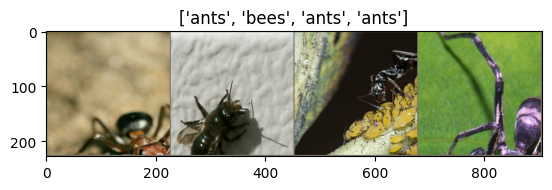

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


inputs, classes = next(iter(dataloaders['train']))

out = utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=0.0001)


In [18]:
best_model_params_path = os.path.join('../resource/resnet', '6-resnet.pt')
model.to(device)
since = time.time()

torch.save(model.state_dict(), best_model_params_path)
best_acc = 0.0
num_epochs = 20

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), best_model_params_path)

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

Epoch 0/19
----------
train Loss: 0.4431 Acc: 0.7992
val Loss: 0.3572 Acc: 0.8562

Epoch 1/19
----------
train Loss: 0.5136 Acc: 0.7705
val Loss: 0.3771 Acc: 0.8627

Epoch 2/19
----------
train Loss: 0.3862 Acc: 0.8238
val Loss: 0.2446 Acc: 0.9085

Epoch 3/19
----------
train Loss: 0.4134 Acc: 0.8197
val Loss: 0.2926 Acc: 0.9020

Epoch 4/19
----------
train Loss: 0.3417 Acc: 0.8689
val Loss: 0.2466 Acc: 0.9085

Epoch 5/19
----------
train Loss: 0.3516 Acc: 0.8484
val Loss: 0.2959 Acc: 0.9020

Epoch 6/19
----------
train Loss: 0.3549 Acc: 0.8443
val Loss: 0.2215 Acc: 0.9412

Epoch 7/19
----------
train Loss: 0.2908 Acc: 0.8934
val Loss: 0.2574 Acc: 0.9346

Epoch 8/19
----------
train Loss: 0.3327 Acc: 0.8770
val Loss: 0.2820 Acc: 0.9085

Epoch 9/19
----------
train Loss: 0.2515 Acc: 0.8770
val Loss: 0.3558 Acc: 0.8758

Epoch 10/19
----------
train Loss: 0.4229 Acc: 0.8279
val Loss: 0.4337 Acc: 0.8105

Epoch 11/19
----------
train Loss: 0.3474 Acc: 0.8279
val Loss: 0.3257 Acc: 0.8758

Ep